# Ternary classification

In [1]:
%matplotlib inline
%precision 2
import warnings; warnings.simplefilter('ignore')
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.calibration import CalibratedClassifierCV
from pycalib.models import CalibratedModel
from pycalib.visualisations import plot_reliability_diagram


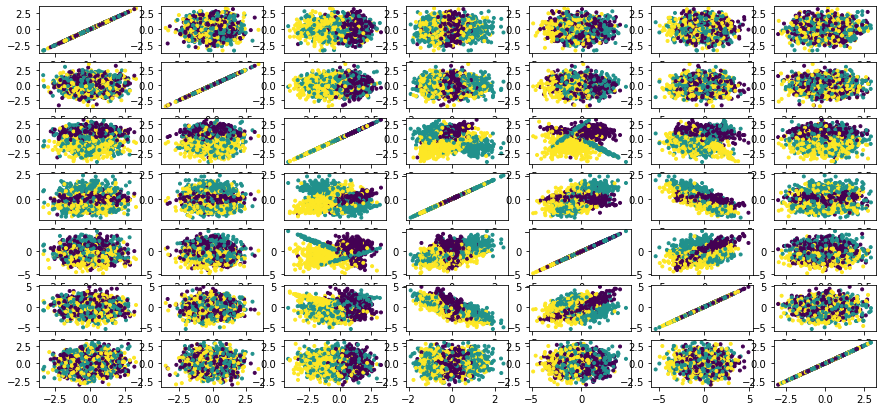

In [2]:
n_features = 7
X, y = datasets.make_classification(n_classes=3, n_samples=10000,
                                    n_clusters_per_class=2,
                                    n_features=n_features,
                                    n_informative=int(n_features/2),
                                    n_redundant=int(n_features/4),
                                    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8,
                                                    random_state=42)

fig = plt.figure(figsize=(15, 7))
for i in range(n_features):
    for j in range(n_features):
        ax = fig.add_subplot(n_features, n_features, 1 + i + j*n_features)
        plt.scatter(X_train[:,i], X_train[:,j], c=y_train, marker='.')

# Reliability diagram

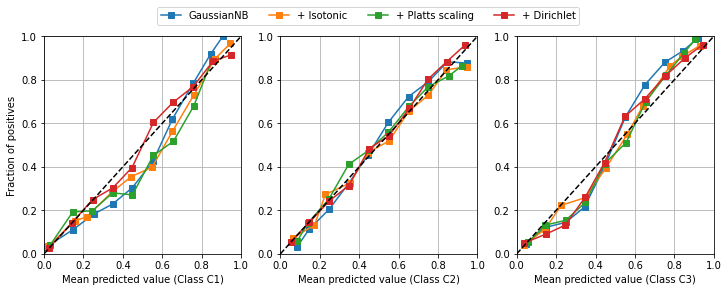

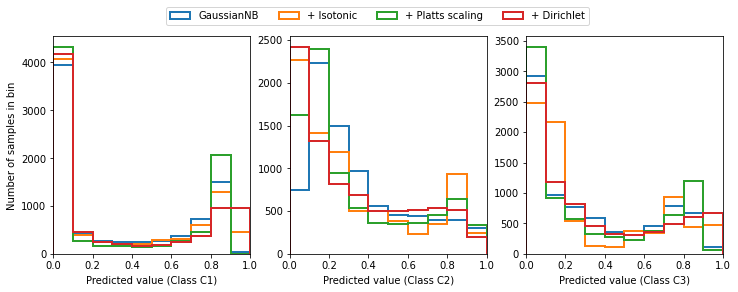

In [3]:
from pycalib.models import IsotonicCalibration
from pycalib.models import SigmoidCalibration
from pycalib.models.multiclass import OneVsRestCalibrator
from dirichletcal import FullDirichletCalibrator

estimators = [(GaussianNB(), 'GaussianNB'),
              (CalibratedModel(GaussianNB(), method=OneVsRestCalibrator(IsotonicCalibration())), '+ Isotonic'),
              (CalibratedModel(GaussianNB(), method=OneVsRestCalibrator(SigmoidCalibration())), '+ Platts scaling'),
              (CalibratedModel(GaussianNB(), method=FullDirichletCalibrator()), '+ Dirichlet')
             ]

legend = [aux[1] for aux in estimators]
scores = []
for clf, name in estimators:
    clf.fit(X_train, y_train)
    scores.append(clf.predict_proba(X_test))
    
_ = plot_reliability_diagram(y_test, scores, legend=legend, histogram=True, class_names=['C1', 'C2', 'C3'])

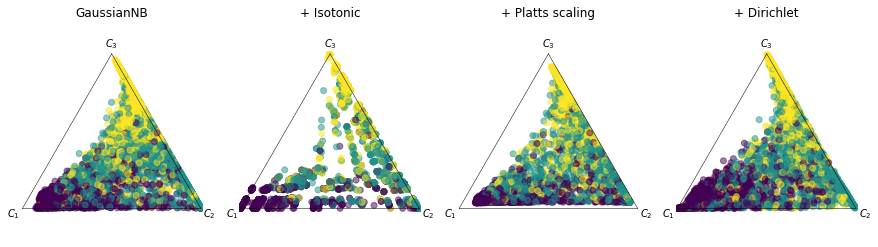

In [4]:
from pycalib.visualisations.ternary import draw_tri_samples

fig = plt.figure(figsize=(15, 4))
for i, (clf, name) in enumerate(estimators):
    ax = fig.add_subplot(1, len(estimators), i+1)
    fig, ax = draw_tri_samples(clf.predict_proba(X_test), classes=y_test, fig=fig, ax=ax, alpha=0.5)
    ax.set_title(name)

# 2D slices of 3D calibration maps

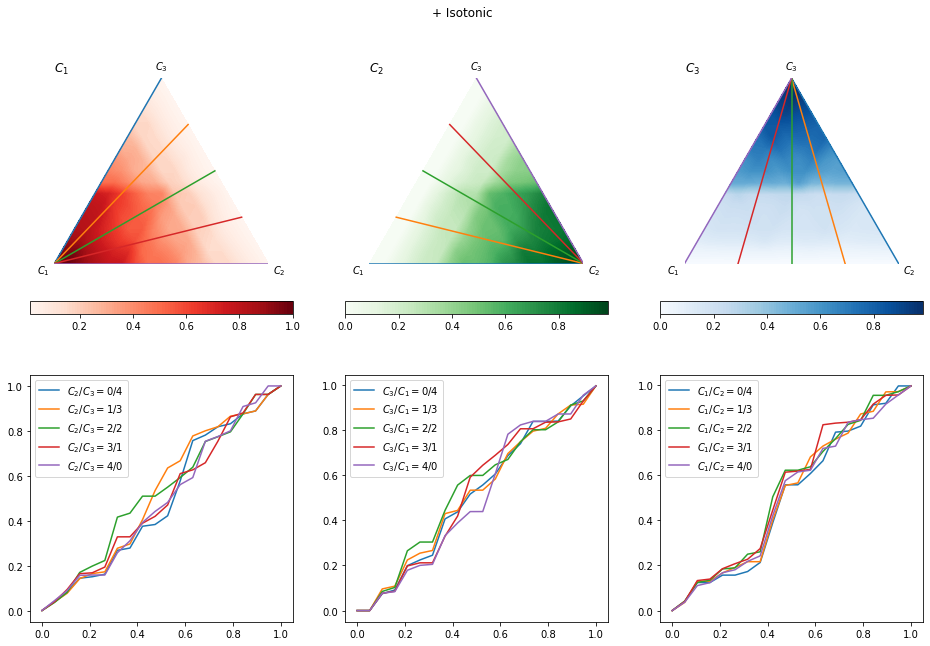

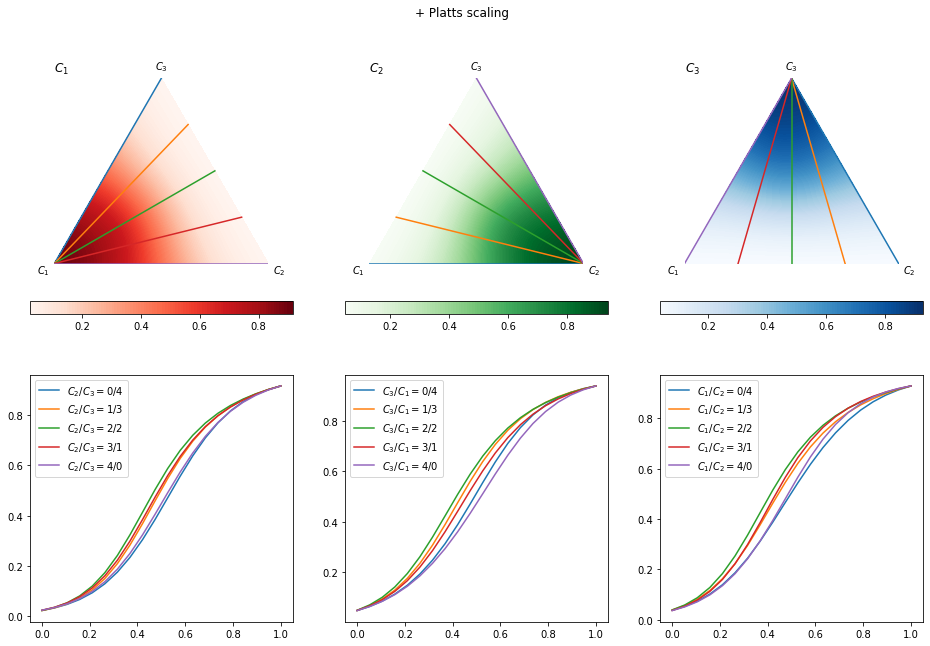

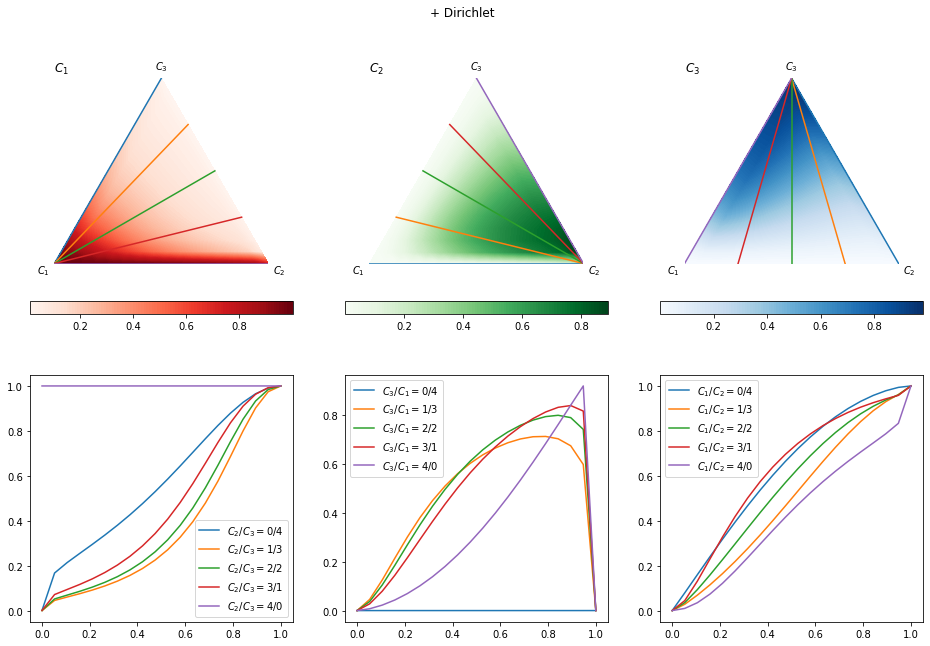

In [5]:
from pycalib.visualisations.ternary import draw_func_contours, plot_converging_lines_pvalues, get_converging_lines

c_mark = [{'color':[.5, 0, 0], 'marker':'.', 'label':r'$C_1$', 'cmap':'Reds'},
          {'color':[0, .5, 0], 'marker':'x', 'label':r'$C_2$', 'cmap':'Greens'},
          {'color':[0, 0, .5], 'marker':'+', 'label':r'$C_3$', 'cmap':'Blues'}]


for i, (clf, name) in enumerate(estimators):
    if not hasattr(clf, 'calibrator'):
        continue
        
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle(name)
    for i, c in enumerate(['C1', 'C2', 'C3']):
        ax = fig.add_subplot(2, 3, i+1)

        ax.set_title('$C_{}$'.format(i+1), loc='left')

        function = lambda x: clf.calibrator.predict_proba(x.reshape(1,-1))[0][i]
        draw_func_contours(function, labels='auto', fig=fig, ax=ax, cmap=c_mark[i]['cmap'],
                           nlevels=100, subdiv=4, draw_lines=5, class_index=i)

        ax2 = fig.add_subplot(2, 3, 3+i+1)
        lines = get_converging_lines(num_lines=5, mesh_precision=20, class_index=i)
        plot_converging_lines_pvalues(function, lines, i, ax2)

# Calibration map for the winning class



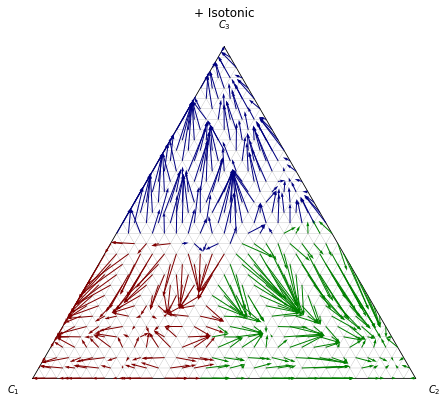

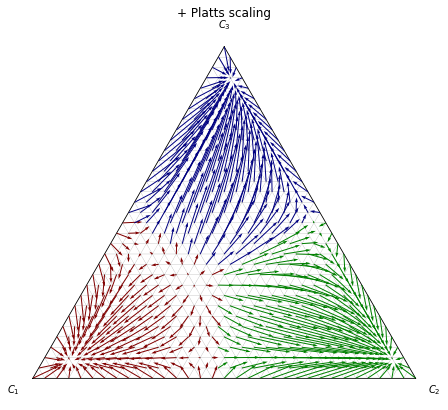

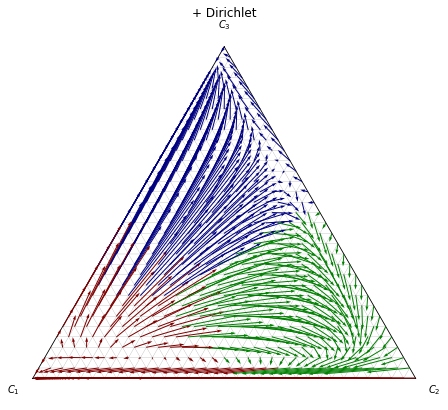

In [6]:
from pycalib.visualisations.barycentric import draw_calibration_map
from pycalib.visualisations.barycentric import get_mesh_bc
from pycalib.models import CalibratedModel

from dirichletcal import FullDirichletCalibrator, FixedDiagonalDirichletCalibrator, DirichletCalibrator

P_bc_grid = get_mesh_bc(subdiv=5)

for clf, name in estimators:
    if not hasattr(clf, 'calibrator'):
        continue
    calibrated = clf.calibrator.predict_proba(P_bc_grid)
    color = [c_mark[i]['color'] for i in calibrated.argmax(axis=1).astype(int)]
    fig = plt.figure(figsize=(7, 7))
    draw_calibration_map(P_bc_grid, calibrated, color=color,  subdiv=5, fig=fig)
    plt.title(name)

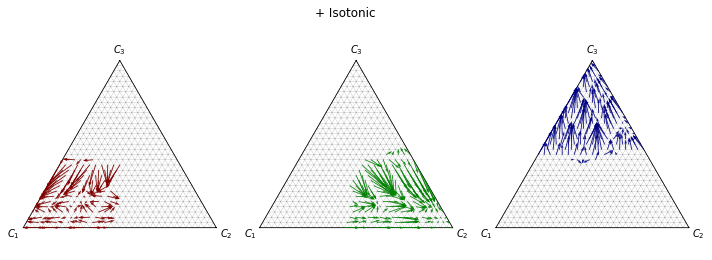

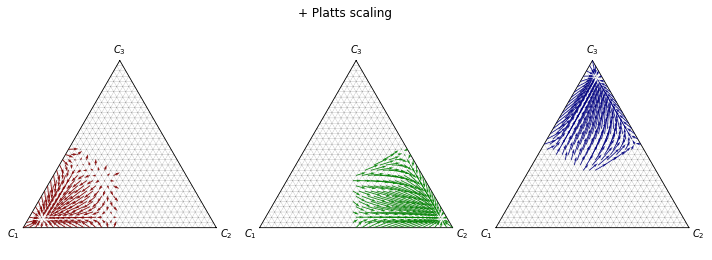

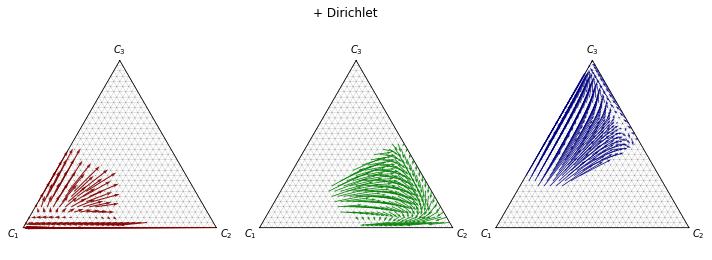

In [7]:
from pycalib.visualisations.barycentric import draw_calibration_map
from pycalib.visualisations.barycentric import get_mesh_bc
from pycalib.models import CalibratedModel

from dirichletcal import FullDirichletCalibrator, FixedDiagonalDirichletCalibrator, DirichletCalibrator

P_bc_grid = get_mesh_bc(subdiv=5)

for clf, name in estimators:
    if not hasattr(clf, 'calibrator'):
        continue
    calibrated = clf.calibrator.predict_proba(P_bc_grid)
    
    fig = plt.figure(figsize=(12, 4))
    fig.suptitle(name)
    for i in range(3):
        ax = fig.add_subplot(1, 3, i+1)
        indices = calibrated.argmax(axis=1) == i
        color = c_mark[i]['color']
        draw_calibration_map(P_bc_grid[indices], calibrated[indices], color=color,
                               subdiv=5, fig=fig, ax=ax, alpha=0.9) #, scale_units='xy')
    #draw_calibration_map(P_bc_grid, calibrated)

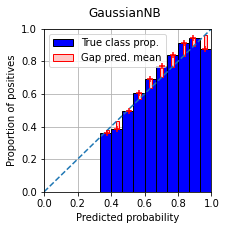

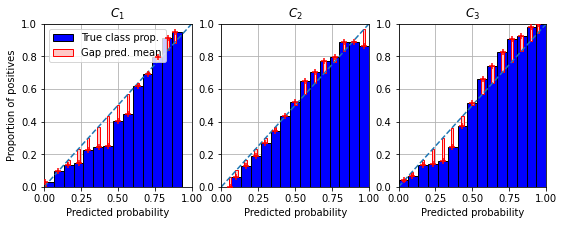

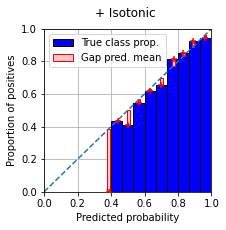

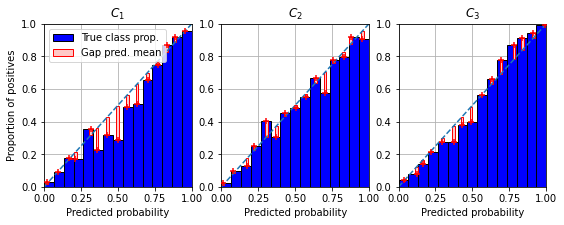

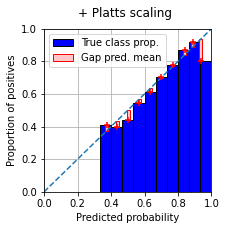

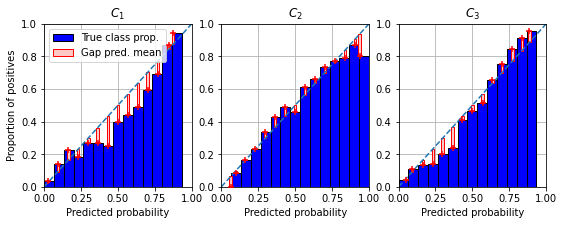

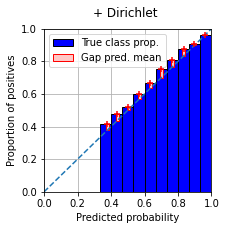

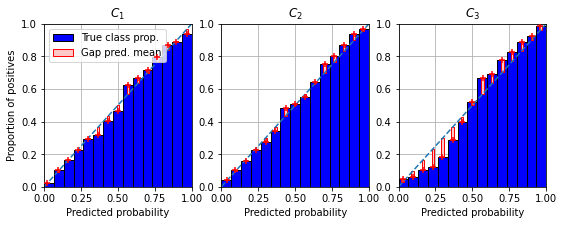

In [8]:
from pycalib.visualisations import plot_multiclass_reliability_diagram_gaps

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(categories='auto')
Y_test = ohe.fit_transform(y_test.reshape(-1, 1))


# Reliability diagrams
for i, (clf, name) in enumerate(estimators):
    fig = plt.figure(figsize=(3, 3))
    fig.suptitle(name)
    
    probas = clf.predict_proba(X_test)
    plot_multiclass_reliability_diagram_gaps(Y_test, probas, fig=fig, per_class=False)
    
    fig = plt.figure(figsize=(9, 3))
    ax = [fig.add_subplot(1, 3, j+1) for j in range(3)]
    plot_multiclass_reliability_diagram_gaps(Y_test, probas, fig=fig, ax=ax, per_class=True)

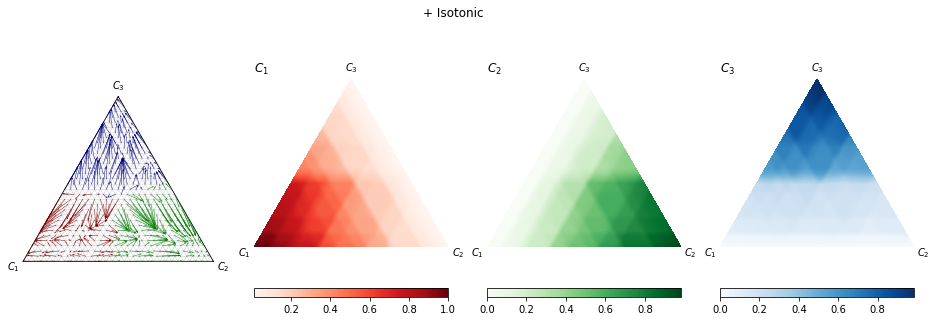

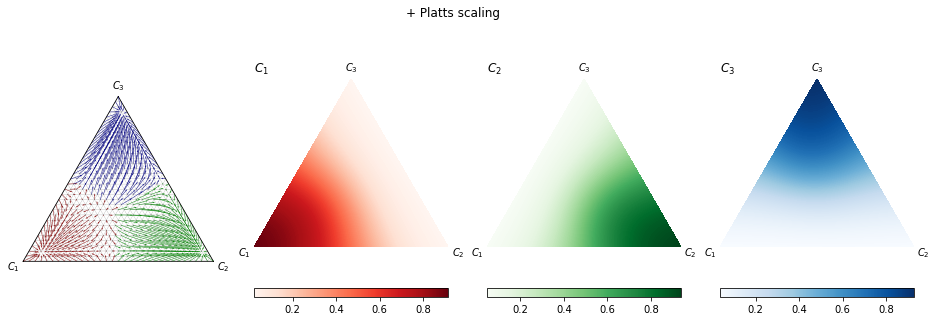

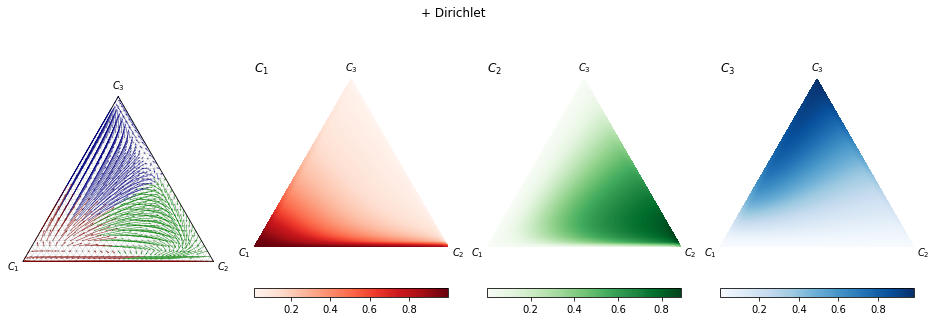

In [9]:
P_bc_grid = get_mesh_bc(subdiv=5)

for j, (clf, cal_name) in enumerate(estimators):
    if not hasattr(clf, 'calibrator'):
        continue
    calibrated = clf.calibrator.predict_proba(P_bc_grid)
    
    color = [c_mark[i]['color'] for i in calibrated.argmax(axis=1).astype(int)]

    fig = plt.figure(figsize=(16, 5))
    fig.suptitle(cal_name, fontsize=12)
    ax = fig.add_subplot(1, 4, 1)
    fig = draw_calibration_map(P_bc_grid, calibrated, color=color, subdiv=5, fig=fig, ax=ax, alpha=0.9)
    
    for i, c in enumerate(['C1', 'C2', 'C3']):
        ax = fig.add_subplot(1, 4, i+2)
        ax.set_title('$C_{}$'.format(i+1), loc='left')

        function = lambda x: clf.calibrator.predict_proba(x.reshape(1,-1))[0][i]
        draw_func_contours(function, labels='auto', fig=fig, ax=ax, cmap=c_mark[i]['cmap'])